# PreActResNet-9 on CIFAR-10 Dataset

Importing PyTorch and a few Python Libraries

In [1]:
pip install torch-summary

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import sys
import time
import math

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
from torchvision.utils import make_grid

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.nn.init as init

from torchsummary import summary

import matplotlib.pyplot as plt
%matplotlib inline

## Preparing the dataset

We will be downloading the train and test CIFAR-10 dataset from torchvision. We will normalize and transform the dataset. For the training dataset, we will also be adding Random Crops and Random Horizontal Flips to generalize the model better.

In [3]:
data_statistics = (
    (0.49139968, 0.48215827, 0.44653124),
     (0.24703233, 0.24348505, 0.26158768)
) # Mean, Standard Deviation of CIFAR-10 dataset channels

train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'), # Adding Random Crops
    transforms.RandomHorizontalFlip(), # Adding Random Horizontal Flips
    transforms.ToTensor(), # Channel x Image Height x Image Width
    transforms.Normalize(*data_statistics, inplace=True) # Output in the range of [-1, 1]
])

test_transforms = transforms.Compose([
    transforms.ToTensor(), # Channel x Image Height x Image Width
    transforms.Normalize(*data_statistics, inplace=True) # Output in the range of [-1, 1]
])

In [4]:
train_dataset = torchvision.datasets.CIFAR10(root='./data/', download=True, train=True, transform=train_transforms)
test_dataset = torchvision.datasets.CIFAR10(root='./data/', download=True, train=False, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


<!-- We will also be splitting the dataset further into training and validation dataset with a validation ratio of `0.2` -->

We will now create data loaders to retreive images in batches. We are selecting the batch size as `128` images for our train loader. And we are selecting the batch size as `100` images for our test loader.

*From PyTorch Documentation: For data loading, passing pin_memory=True to a DataLoader will automatically put the fetched data Tensors in pinned memory, and thus enables faster data transfer to CUDA-enabled GPUs.*

In [5]:
# validation_ratio = 0.2
# train_dataset, validation_dataset = random_split(
#     dataset,
#     [int((1 - validation_ratio) * len(dataset)), int(validation_ratio * len(dataset))]
# )

train_batch_size = 128
test_batch_size = 100

train_dl = DataLoader(train_dataset, train_batch_size, shuffle=True, num_workers=2, pin_memory=True)
# validation_dl = DataLoader(validation_dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True)
test_dl = DataLoader(test_dataset, test_batch_size, shuffle=False, num_workers=2, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

We create the following function to display a batch of images from the dataset. And we also need to denormalize the pixels values to bring them back into the range (0,1).

In [6]:
def denormalize(images, means, stds):
  means = torch.tensor(means).reshape(1, 3, 1, 1)
  stds = torch.tensor(stds).reshape(1, 3, 1, 1)
  return images * stds + means

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([])
    ax.set_yticks([])
    denorm_images = denormalize(images, *data_statistics)
    ax.imshow(make_grid(denorm_images[:64], 8).permute(1, 2, 0))
    break

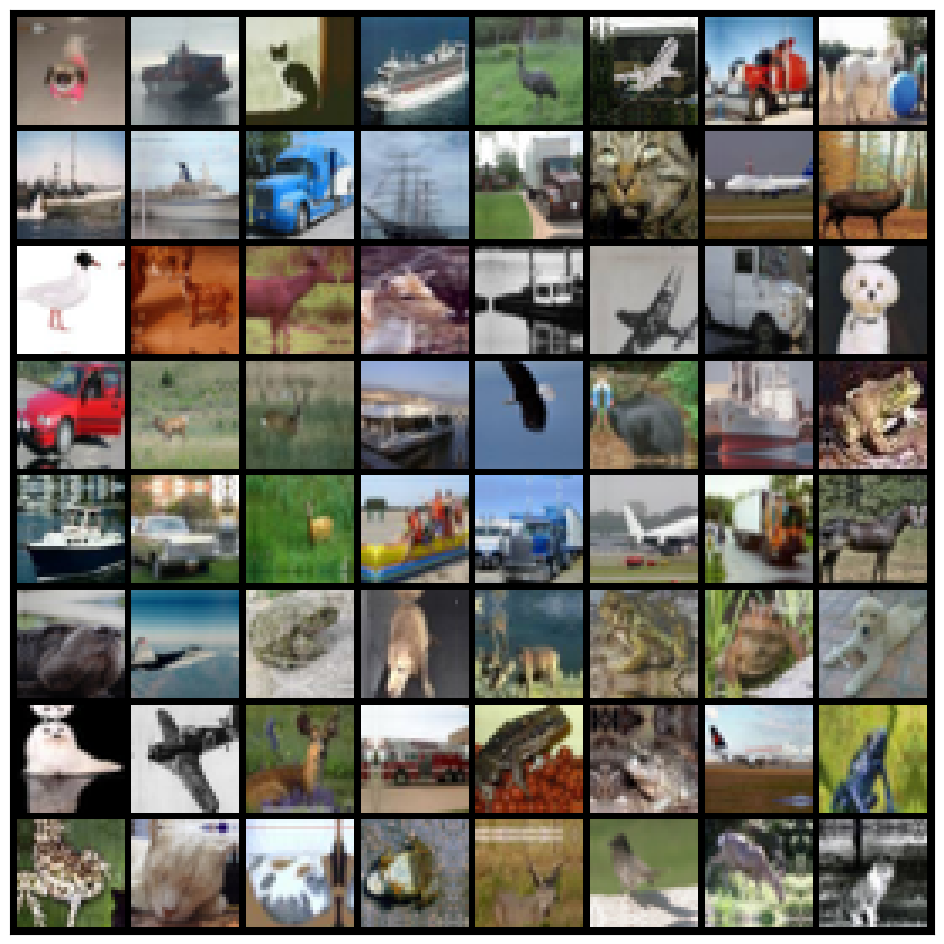

In [7]:
show_batch(train_dl)

To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU as required.

In [8]:
def get_default_device():
  # Pick GPU, if available, else CPU
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  # Move tensors to chosen device
  if isinstance(data, (list, tuple)):
    # If the instance is a list/tuple, transfer each element to chosen device
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)
  # non_blocking=True doesn't block the execution of the host device until transfers complete

class DeviceDataLoader():
  # Wrap a dataloader to move data to a device
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    # Yield a batch of data after moving it to device
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    # Number of batches
    return len(self.dl)

In [9]:
# Get the default device
device = get_default_device()
device

device(type='cuda')

In [10]:
train_dl = DeviceDataLoader(train_dl, device)
# validation_dl = DeviceDataLoader(validation_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

## Network Architecture

Testing the models mentioned in the `pytorch-cifar` [GitHub Repository](https://github.com/kuangliu/pytorch-cifar).

### PreActResNet18

In [11]:
class PreActBlock(nn.Module):
  '''Pre-activation version of the BasicBlock.'''
  expansion = 1

  def __init__(self, in_planes, planes, stride=1):
    super(PreActBlock, self).__init__()
    self.bn1 = nn.BatchNorm2d(in_planes)
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

    if stride != 1 or in_planes != self.expansion*planes:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
      )

  def forward(self, x):
    out = F.relu(self.bn1(x))
    shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
    out = self.conv1(out)
    out = self.conv2(F.relu(self.bn2(out)))
    out += shortcut
    return out

class PreActResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes=10):
    super(PreActResNet, self).__init__()
    self.in_planes = 64

    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
    self.linear = nn.Linear(512*block.expansion, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1)
    layers = []
    for stride in strides:
        layers.append(block(self.in_planes, planes, stride))
        self.in_planes = planes * block.expansion
    return nn.Sequential(*layers)

  def forward(self, x):
    out = self.conv1(x)
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out

def PreActResNet18():
  return PreActResNet(PreActBlock, [2,2,2,2])

In [12]:
# model = PreActResNet18()

The number of parameters is `11,171,146`, which exceeds the 5 million limit.

### ResNet18

In [13]:
class BasicBlock(nn.Module):
  expansion = 1

  def __init__(self, in_planes, planes, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(
        in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                            stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, self.expansion*planes,
                    kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(self.expansion*planes)
      )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes=10):
    super(ResNet, self).__init__()
    self.in_planes = 64

    self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                            stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
    self.linear = nn.Linear(512*block.expansion, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1)
    layers = []
    for stride in strides:
      layers.append(block(self.in_planes, planes, stride))
      self.in_planes = planes * block.expansion
    return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out

def ResNet18():
  return ResNet(BasicBlock, [2, 2, 2, 2])

In [14]:
# model = ResNet18()

The number of parameters is `11,173,962`, which exceeds the 5 million limit.

### ResNet9

In [15]:
def ResNet9():
  return ResNet(BasicBlock, [1, 1, 1, 1])

In [16]:
# model = ResNet9()

### PreActResNet9

In [17]:
def PreActResNet9():
  return PreActResNet(PreActBlock, [1,1,1,1])

In [18]:
model = PreActResNet9()

In [19]:
model =  model.to(device)
if device == 'cuda':
  model = torch.nn.DataParallel(model)
  cudnn.benchmark = True

In [20]:
summary(model, input_size=(3, 32, 32))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            1,728
├─Sequential: 1-2                        --
|    └─PreActBlock: 2-1                  --
|    |    └─BatchNorm2d: 3-1             128
|    |    └─Conv2d: 3-2                  36,864
|    |    └─BatchNorm2d: 3-3             128
|    |    └─Conv2d: 3-4                  36,864
├─Sequential: 1-3                        --
|    └─PreActBlock: 2-2                  --
|    |    └─BatchNorm2d: 3-5             128
|    |    └─Conv2d: 3-6                  73,728
|    |    └─BatchNorm2d: 3-7             256
|    |    └─Conv2d: 3-8                  147,456
|    |    └─Sequential: 3-9              8,192
├─Sequential: 1-4                        --
|    └─PreActBlock: 2-3                  --
|    |    └─BatchNorm2d: 3-10            256
|    |    └─Conv2d: 3-11                 294,912
|    |    └─BatchNorm2d: 3-12            512
|    |    └─Conv2d: 3-13                 589,824
|    |    └─Sequential: 3-14    

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            1,728
├─Sequential: 1-2                        --
|    └─PreActBlock: 2-1                  --
|    |    └─BatchNorm2d: 3-1             128
|    |    └─Conv2d: 3-2                  36,864
|    |    └─BatchNorm2d: 3-3             128
|    |    └─Conv2d: 3-4                  36,864
├─Sequential: 1-3                        --
|    └─PreActBlock: 2-2                  --
|    |    └─BatchNorm2d: 3-5             128
|    |    └─Conv2d: 3-6                  73,728
|    |    └─BatchNorm2d: 3-7             256
|    |    └─Conv2d: 3-8                  147,456
|    |    └─Sequential: 3-9              8,192
├─Sequential: 1-4                        --
|    └─PreActBlock: 2-3                  --
|    |    └─BatchNorm2d: 3-10            256
|    |    └─Conv2d: 3-11                 294,912
|    |    └─BatchNorm2d: 3-12            512
|    |    └─Conv2d: 3-13                 589,824
|    |    └─Sequential: 3-14    

## Model Training

In [21]:
# Helper Function
# term_width = int(100)

# TOTAL_BAR_LENGTH = 65.
# last_time = time.time()
# begin_time = last_time

# def progress_bar(current, total, msg=None):
#   global last_time, begin_time
#   if current == 0:
#     begin_time = time.time()  # Reset for new bar.

#   cur_len = int(TOTAL_BAR_LENGTH * current/total)
#   rest_len = int(TOTAL_BAR_LENGTH - cur_len) - 1

#   sys.stdout.write(' [')
#   for i in range(cur_len):
#     sys.stdout.write('=')
#   sys.stdout.write('>')
#   for i in range(rest_len):
#     sys.stdout.write('.')
#   sys.stdout.write(']')

#   cur_time = time.time()
#   step_time = cur_time - last_time
#   last_time = cur_time
#   tot_time = cur_time - begin_time

#   L = []
#   L.append('  Step: %s' % format_time(step_time))
#   L.append(' | Tot: %s' % format_time(tot_time))
#   if msg:
#     L.append(' | ' + msg)

#   msg = ''.join(L)
#   sys.stdout.write(msg)
#   for i in range(term_width-int(TOTAL_BAR_LENGTH)-len(msg)-3):
#     sys.stdout.write(' ')

#   # Go back to the center of the bar.
#   for i in range(term_width-int(TOTAL_BAR_LENGTH/2)+2):
#     sys.stdout.write('\b')
#   sys.stdout.write(' %d/%d ' % (current+1, total))

#   if current < total-1:
#     sys.stdout.write('\r')
#   else:
#     sys.stdout.write('\n')
#   sys.stdout.flush()

In [22]:
def format_time(seconds):
  days = int(seconds / 3600/24)
  seconds = seconds - days*3600*24
  hours = int(seconds / 3600)
  seconds = seconds - hours*3600
  minutes = int(seconds / 60)
  seconds = seconds - minutes*60
  secondsf = int(seconds)
  seconds = seconds - secondsf
  millis = int(seconds*1000)

  f = ''
  i = 1
  if days > 0:
    f += str(days) + 'D'
    i += 1
  if hours > 0 and i <= 2:
    f += str(hours) + 'h'
    i += 1
  if minutes > 0 and i <= 2:
    f += str(minutes) + 'm'
    i += 1
  if secondsf > 0 and i <= 2:
    f += str(secondsf) + 's'
    i += 1
  if millis > 0 and i <= 2:
    f += str(millis) + 'ms'
    i += 1
  if f == '':
    f = '0ms'
  return f

In [23]:
lr = 0.1
momentum = 0.9
weight_decay = 5e-4

start_epoch = 1
number_of_epochs = 150
best_acc = 0


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr,
                      momentum=momentum, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=number_of_epochs)

In [24]:
def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

In [25]:
def train(epoch):
  print('\nEpoch: %d' % epoch)
  start_time = time.time()

  model.train()
  train_loss = 0
  correct = 0
  total = 0
  for batch_idx, (inputs, targets) in enumerate(train_dl):
    # inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = outputs.max(1)
    total += targets.size(0)
    correct += predicted.eq(targets).sum().item()

    if batch_idx % 50 == 0:
      print(f"Batch: {batch_idx}/{len(train_dl)} | Loss: {(train_loss/(batch_idx+1)):.3f} | Acc: {(100.*correct/total):.3f}%")

  cur_time = time.time()
  epoch_time = cur_time - start_time
  print(f"Time taken : {format_time(epoch_time)}")

  return train_loss/(batch_idx+1), 100.*correct/total, get_lr(optimizer)

In [26]:
def test(epoch):
  global best_acc
  model.eval()
  test_loss = 0
  correct = 0
  total = 0
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_dl):
      # inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      test_loss += loss.item()
      _, predicted = outputs.max(1)
      total += targets.size(0)
      correct += predicted.eq(targets).sum().item()
      
      if batch_idx % 50 == 0:
        print(f"Batch: {batch_idx}/{len(test_dl)} | Loss: {(test_loss/(batch_idx+1)):.3f} | Acc: {(100.*correct/total):.3f}%")
      # progress_bar(batch_idx, len(test_dl), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
      #               % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

  # Save checkpoint.
  acc = 100.*correct/total
  if acc > best_acc:
    print('Saving..')
    state = {
        'net': model.state_dict(),
        'acc': acc,
        'epoch': epoch,
    }
    if not os.path.isdir('checkpoint'):
      os.mkdir('checkpoint')
    torch.save(state, './checkpoint/ckpt.pth')
    best_acc = acc

  return test_loss/(batch_idx+1), 100.*correct/total

In [27]:
train_losses = []
train_accuracies = []
train_lrs = []

test_losses = []
test_accuracies = []

for epoch in range(start_epoch, start_epoch + number_of_epochs):
  epoch_train_loss, epoch_train_accuracy, epoch_lr = train(epoch)
  train_losses.append(epoch_train_loss)
  train_accuracies.append(epoch_train_accuracy)
  train_lrs.append(epoch_lr)

  epoch_test_loss, epoch_test_accuracy = test(epoch)
  test_losses.append(epoch_test_loss)
  test_accuracies.append(epoch_test_accuracy)

  scheduler.step()


Epoch: 1
Batch: 0/391 | Loss: 2.294 | Acc: 10.938%
Batch: 50/391 | Loss: 2.149 | Acc: 21.645%
Batch: 100/391 | Loss: 1.975 | Acc: 26.493%
Batch: 150/391 | Loss: 1.889 | Acc: 29.129%
Batch: 200/391 | Loss: 1.823 | Acc: 31.596%
Batch: 250/391 | Loss: 1.781 | Acc: 33.295%
Batch: 300/391 | Loss: 1.737 | Acc: 35.052%
Batch: 350/391 | Loss: 1.698 | Acc: 36.599%
Time taken : 15s465ms
Batch: 0/100 | Loss: 1.363 | Acc: 51.000%
Batch: 50/100 | Loss: 1.323 | Acc: 51.490%
Saving..

Epoch: 2
Batch: 0/391 | Loss: 1.244 | Acc: 53.906%
Batch: 50/391 | Loss: 1.279 | Acc: 53.937%
Batch: 100/391 | Loss: 1.261 | Acc: 54.525%
Batch: 150/391 | Loss: 1.236 | Acc: 55.360%
Batch: 200/391 | Loss: 1.213 | Acc: 56.382%
Batch: 250/391 | Loss: 1.197 | Acc: 56.807%
Batch: 300/391 | Loss: 1.182 | Acc: 57.465%
Batch: 350/391 | Loss: 1.162 | Acc: 58.153%
Time taken : 15s207ms
Batch: 0/100 | Loss: 0.978 | Acc: 70.000%
Batch: 50/100 | Loss: 1.058 | Acc: 63.843%
Saving..

Epoch: 3
Batch: 0/391 | Loss: 1.081 | Acc: 67.188

In [28]:
def plot_accuracies(train_accuracies, test_accuracies):
  plt.plot(train_accuracies, label='Train Accuracy')
  plt.plot(test_accuracies, label='Test Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)
  plt.title('Accuracy vs. No. of epochs')

In [29]:
def plot_losses(train_losses, test_losses):
  plt.plot(train_losses, label='Train Losses')
  plt.plot(test_losses, label='Test Losses')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.title('Loss vs. No. of epochs')

In [30]:
def plot_lrs(train_lrs):
  plt.plot(train_lrs)
  plt.xlabel('Epochs')
  plt.ylabel('Learning rate')
  plt.grid(True)
  plt.title('Learning Rate vs. Epochs')

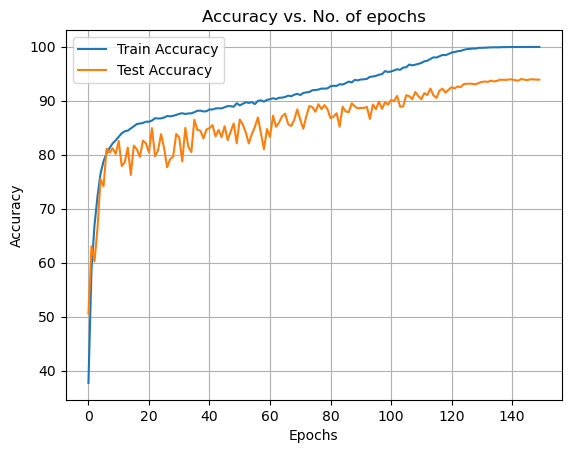

In [31]:
plot_accuracies(train_accuracies, test_accuracies)

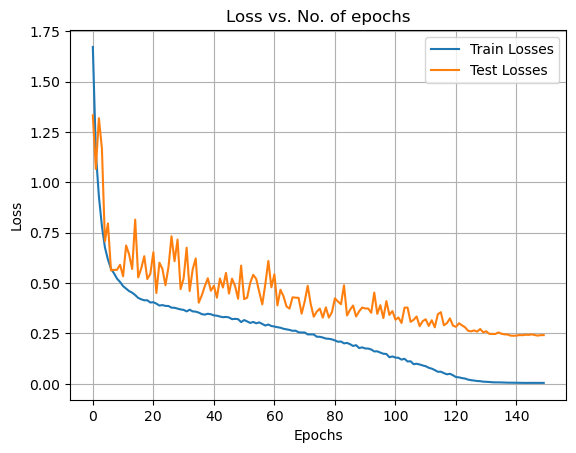

In [32]:
plot_losses(train_losses, test_losses)

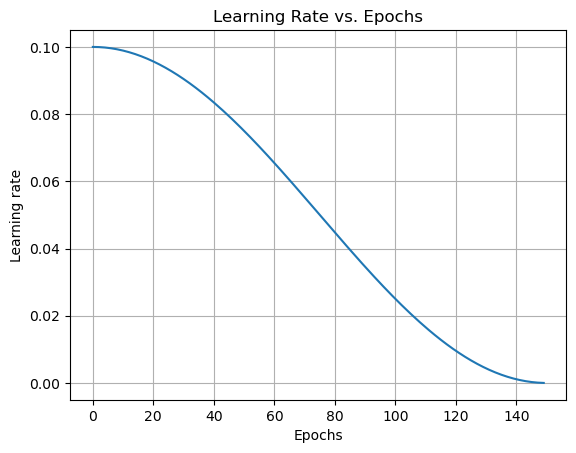

In [33]:
plot_lrs(train_lrs)

In [34]:
print('Saving final model..')
state = {
    'net': model.state_dict(),
    'acc': test_accuracies[-1],
    'epoch': number_of_epochs,
}
if not os.path.isdir('checkpoint'):
  os.mkdir('checkpoint')
torch.save(state, './checkpoint/model_final.pth')

Saving final model..


dict_keys(['net', 'acc', 'epoch'])


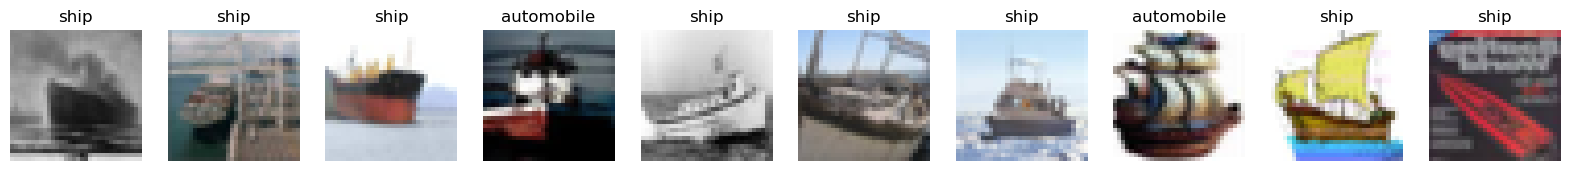

In [36]:
import numpy as np
import pickle
from tqdm import tqdm
import pandas as pd

# Function to load CIFAR batch
def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
    return batch

# Specify the folder where the CIFAR-10 batch files are
cifar10_dir = './data/cifar-10-batches-py'

# Load the label names
meta_data_dict = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
label_names = meta_data_dict[b'label_names']

# Load test data
test_batch = load_cifar_batch('./cifar_test_nolabels.pkl')
test_images = test_batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

data_statistics = (
    (0.49139968, 0.48215827, 0.44653124),
     (0.24703233, 0.24348505, 0.26158768)
)

# Define transformation for data augmentation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*data_statistics, inplace=True)
])

# Apply data augmentation
augmented_test_images = torch.stack([transform(image) for image in test_images])

# Load the trained model
model = PreActResNet9()

final = torch.load('./checkpoint/ckpt.pth')
# final = torch.load('./checkpoint/model_final.pth')

# Check the keys in the checkpoint dictionary
print(final.keys())

# Assuming the model state dictionary is saved under a different key
# Adjust this according to the actual key in your checkpoint file
model.load_state_dict(final['net'])

model =  model.to(device)
augmented_test_images = augmented_test_images.to(device)

# Evaluate the model on test data
model.eval()
with torch.no_grad():
    outputs = model(augmented_test_images)
_, predicted = torch.max(outputs, 1)

predicted = predicted.to('cpu')

# Display the first 10 test images and predicted labels
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(test_images[i])
    plt.title(label_names[predicted[i].item()].decode('utf-8'))
    plt.axis('off')
plt.show()

# Save the output in output.csv containing ID, Labels
output_data = {'ID': np.arange(len(predicted)), 'Labels': predicted.numpy()}
output_df = pd.DataFrame(output_data)
output_df.to_csv('output_rugved_preactresnet9_2.csv', index=False)

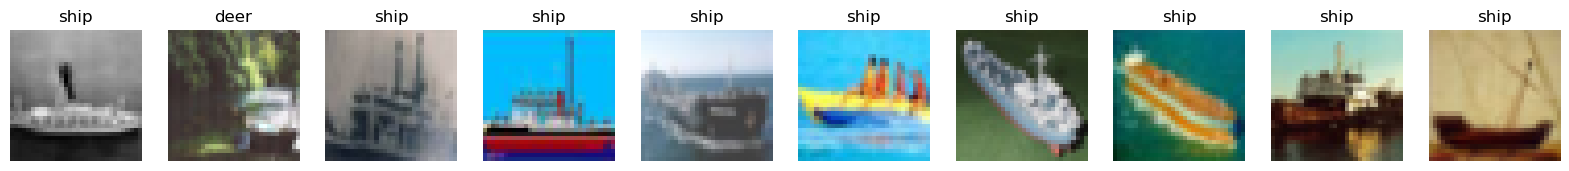

In [37]:
start_index = 10

# Display the second 10 test images and predicted labels
plt.figure(figsize=(20, 4))
for i in range(start_index, start_index + 10):
    plt.subplot(1, 10, i - start_index + 1)
    plt.imshow(test_images[i])
    plt.title(label_names[predicted[i].item()].decode('utf-8'))
    plt.axis('off')
plt.show()

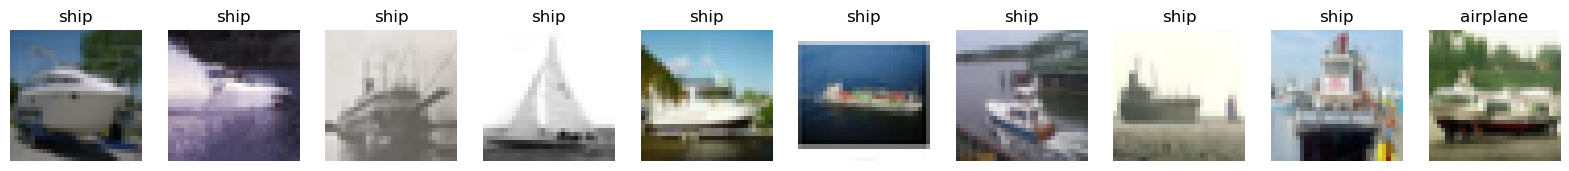

In [38]:
start_index = 20

# Display the second 10 test images and predicted labels
plt.figure(figsize=(20, 4))
for i in range(start_index, start_index + 10):
    plt.subplot(1, 10, i - start_index + 1)
    plt.imshow(test_images[i])
    plt.title(label_names[predicted[i].item()].decode('utf-8'))
    plt.axis('off')
plt.show()

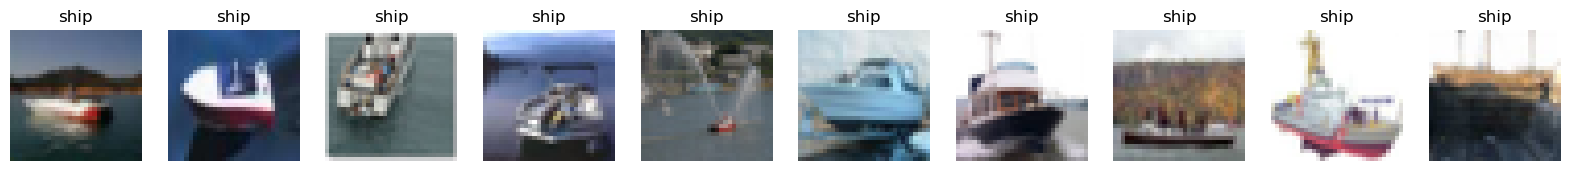

In [39]:
start_index = 30

# Display the second 10 test images and predicted labels
plt.figure(figsize=(20, 4))
for i in range(start_index, start_index + 10):
    plt.subplot(1, 10, i - start_index + 1)
    plt.imshow(test_images[i])
    plt.title(label_names[predicted[i].item()].decode('utf-8'))
    plt.axis('off')
plt.show()

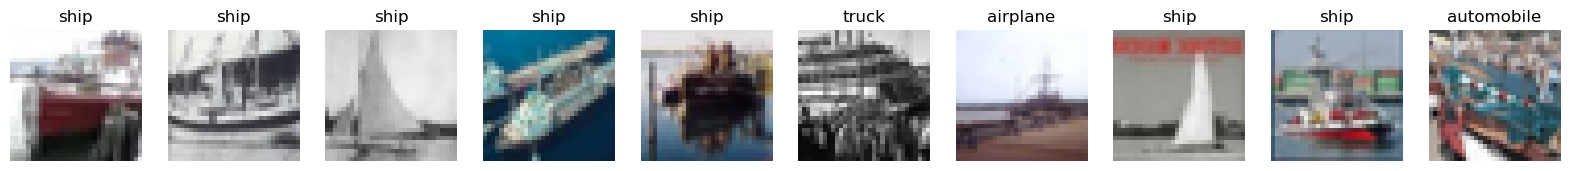

In [40]:
start_index = 40

# Display the second 10 test images and predicted labels
plt.figure(figsize=(20, 4))
for i in range(start_index, start_index + 10):
    plt.subplot(1, 10, i - start_index + 1)
    plt.imshow(test_images[i])
    plt.title(label_names[predicted[i].item()].decode('utf-8'))
    plt.axis('off')
plt.show()

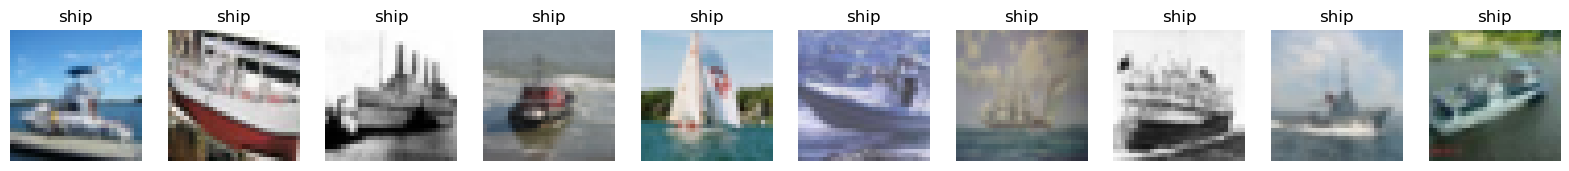

In [41]:
start_index = 100

# Display the second 10 test images and predicted labels
plt.figure(figsize=(20, 4))
for i in range(start_index, start_index + 10):
    plt.subplot(1, 10, i - start_index + 1)
    plt.imshow(test_images[i])
    plt.title(label_names[predicted[i].item()].decode('utf-8'))
    plt.axis('off')
plt.show()

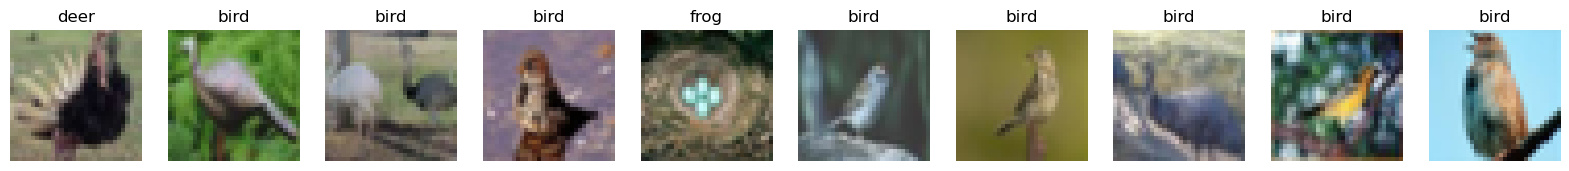

In [42]:
start_index = 1000

# Display the second 10 test images and predicted labels
plt.figure(figsize=(20, 4))
for i in range(start_index, start_index + 10):
    plt.subplot(1, 10, i - start_index + 1)
    plt.imshow(test_images[i])
    plt.title(label_names[predicted[i].item()].decode('utf-8'))
    plt.axis('off')
plt.show()

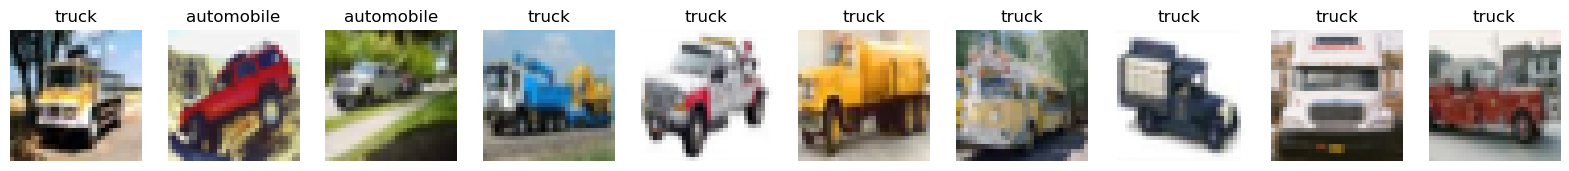

In [43]:
start_index = 2000

# Display the second 10 test images and predicted labels
plt.figure(figsize=(20, 4))
for i in range(start_index, start_index + 10):
    plt.subplot(1, 10, i - start_index + 1)
    plt.imshow(test_images[i])
    plt.title(label_names[predicted[i].item()].decode('utf-8'))
    plt.axis('off')
plt.show()

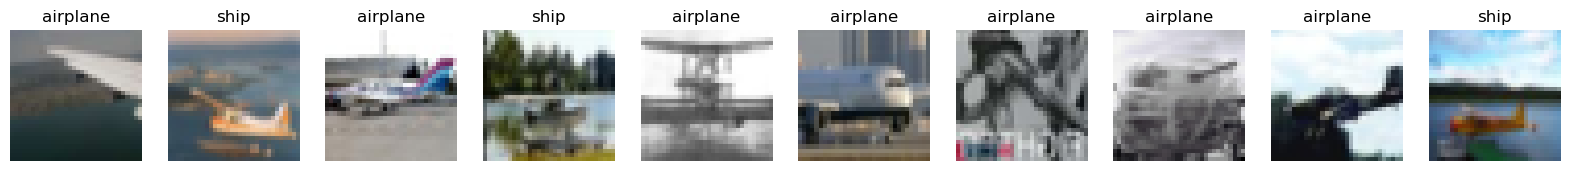

In [44]:
start_index = 3000

# Display the second 10 test images and predicted labels
plt.figure(figsize=(20, 4))
for i in range(start_index, start_index + 10):
    plt.subplot(1, 10, i - start_index + 1)
    plt.imshow(test_images[i])
    plt.title(label_names[predicted[i].item()].decode('utf-8'))
    plt.axis('off')
plt.show()

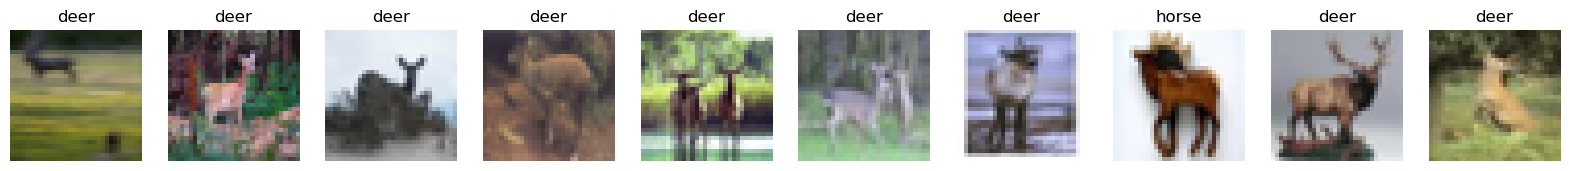

In [45]:
start_index = 4000

# Display the second 10 test images and predicted labels
plt.figure(figsize=(20, 4))
for i in range(start_index, start_index + 10):
    plt.subplot(1, 10, i - start_index + 1)
    plt.imshow(test_images[i])
    plt.title(label_names[predicted[i].item()].decode('utf-8'))
    plt.axis('off')
plt.show()

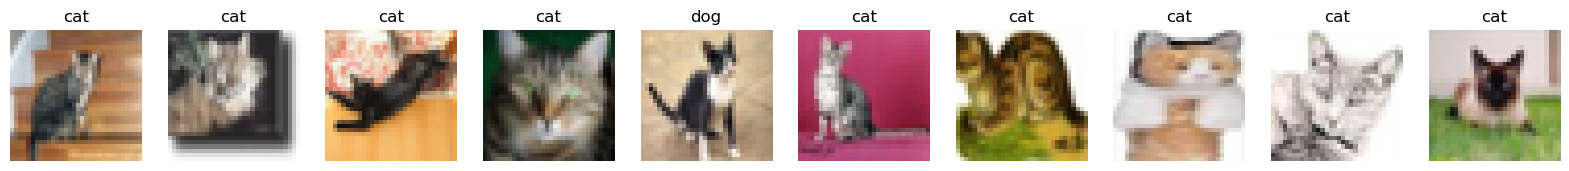

In [46]:
start_index = 5000

# Display the second 10 test images and predicted labels
plt.figure(figsize=(20, 4))
for i in range(start_index, start_index + 10):
    plt.subplot(1, 10, i - start_index + 1)
    plt.imshow(test_images[i])
    plt.title(label_names[predicted[i].item()].decode('utf-8'))
    plt.axis('off')
plt.show()

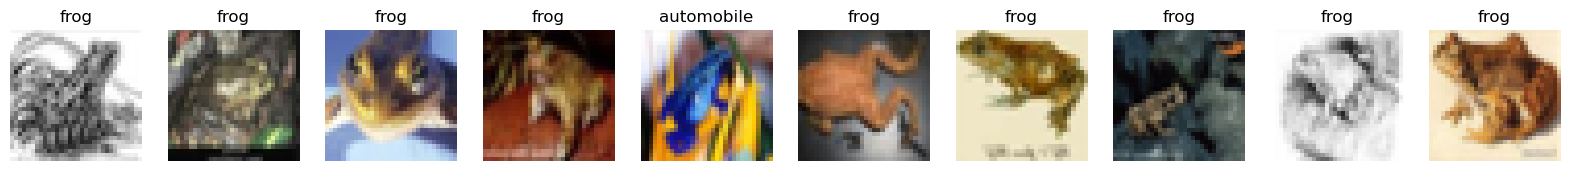

In [47]:
start_index = 6000

# Display the second 10 test images and predicted labels
plt.figure(figsize=(20, 4))
for i in range(start_index, start_index + 10):
    plt.subplot(1, 10, i - start_index + 1)
    plt.imshow(test_images[i])
    plt.title(label_names[predicted[i].item()].decode('utf-8'))
    plt.axis('off')
plt.show()

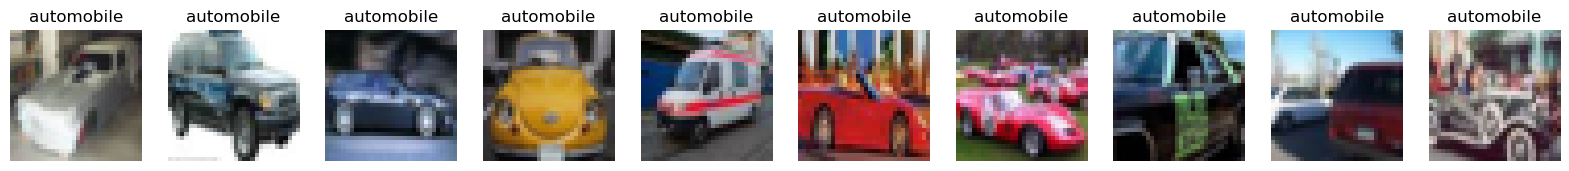

In [48]:
start_index = 7000

# Display the second 10 test images and predicted labels
plt.figure(figsize=(20, 4))
for i in range(start_index, start_index + 10):
    plt.subplot(1, 10, i - start_index + 1)
    plt.imshow(test_images[i])
    plt.title(label_names[predicted[i].item()].decode('utf-8'))
    plt.axis('off')
plt.show()

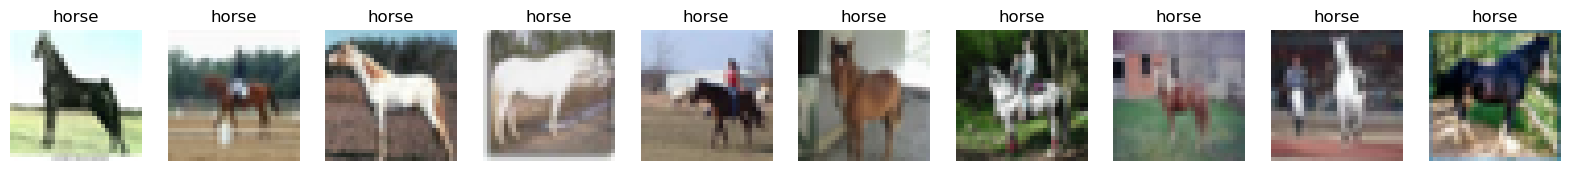

In [49]:
start_index = 8000

# Display the second 10 test images and predicted labels
plt.figure(figsize=(20, 4))
for i in range(start_index, start_index + 10):
    plt.subplot(1, 10, i - start_index + 1)
    plt.imshow(test_images[i])
    plt.title(label_names[predicted[i].item()].decode('utf-8'))
    plt.axis('off')
plt.show()

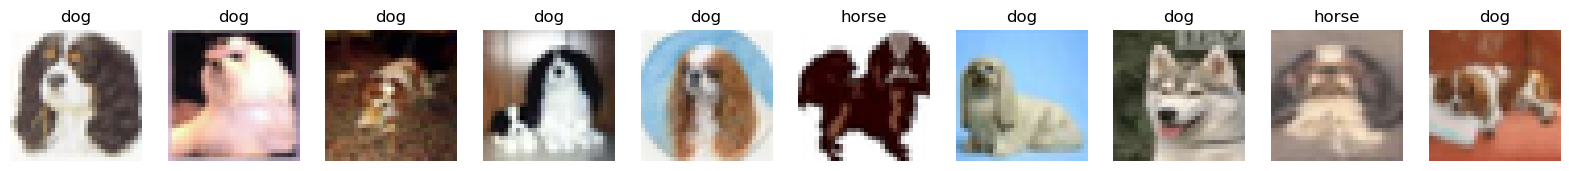

In [50]:
start_index = 9000

# Display the second 10 test images and predicted labels
plt.figure(figsize=(20, 4))
for i in range(start_index, start_index + 10):
    plt.subplot(1, 10, i - start_index + 1)
    plt.imshow(test_images[i])
    plt.title(label_names[predicted[i].item()].decode('utf-8'))
    plt.axis('off')
plt.show()